In [36]:
import os
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [146]:
#adata = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/zebrafish_new/zebrafish_processed.h5ad")
#cts_meso = adata[adata.obs["germ_layer"].isin(["mesoderm", 'mesoderm/neural crest', 'mesoderm/ectoderm'])].obs["cell_type_broad"].unique()
cts_meso = adata[adata.obs["germ_layer"].isin(['mesoderm'])].obs["cell_type_broad"].unique()

In [147]:
len(cts_meso)

36

In [148]:
data_dir = "/lustre/groups/ml01/workspace/cell_flow_zebrafish/results/single_condition/interpolate_time"

In [149]:
gene_target = "tbx16_control"

In [150]:
df_pert = pd.read_csv(os.path.join(data_dir, f"interpolated_{gene_target}_obs.csv"))

In [151]:
df_pert = df_pert[df_pert["cell_type_broad"].isin(cts_meso)]

In [152]:
df_pert.shape

(254595, 5)

In [153]:
df_pert["logtime"] = df_pert.apply(lambda x: float(x["condition"].split("_")[-1][:4]), axis=1)

In [154]:
df_pert.head(-5)

,Unnamed: 0,condition,cell_type_broad_transfer,cell_type_broad_transfer_score,cell_type_broad,logtime
21,21,tbx16_control_2.8903717578961645,mesodermal progenitor cells (contains PSM),1.0,mesodermal progenitor cells (contains PSM),2.89
23,23,tbx16_control_2.8903717578961645,head mesenchyme/PA cartilage,1.0,head mesenchyme/PA cartilage,2.89
26,26,tbx16_control_2.8903717578961645,mature fast muscle,1.0,mature fast muscle,2.89
30,30,tbx16_control_2.8903717578961645,red blood cell,1.0,red blood cell,2.89
31,31,tbx16_control_2.8903717578961645,cranial muscle (progenitor),1.0,cranial muscle (progenitor),2.89
...,...,...,...,...,...,...
999966,999966,tbx16_control_3.1780538303479453,fast-committed myocyte (fusing),1.0,fast-committed myocyte (fusing),3.17
999967,999967,tbx16_control_3.1780538303479453,mesodermal progenitor cells (contains PSM),1.0,mesodermal progenitor cells (contains PSM),3.17
999969,999969,tbx16_control_3.1780538303479453,pronephros distal tubule,1.0,pronephros distal tubule,3.17
999972,999972,tbx16_control_3.1780538303479453,"endothelium (f8+, clic2+)",1.0,"endothelium (f8+, clic2+)",3.17


In [155]:
ct_dists = {}
for lt in df_pert["logtime"].unique():
    df_tmp = df_pert[df_pert["logtime"]==lt]
    ct_tmp = df_tmp["cell_type_broad"].value_counts().to_frame()
    ct_tmp["counts_normalized"] = ct_tmp["count"]/ct_tmp["count"].sum()
    ct_tmp["log_counts_normalized"] = ct_tmp["counts_normalized"]# np.log2(ct_tmp["counts_normalized"]+1+1e-6)
    ct_tmp["norm"] = ct_tmp["log_counts_normalized"]/ct_tmp["log_counts_normalized"].sum()
    ct_tmp["cell_type_broad"] = ct_tmp.index
    ct_dists[lt] = ct_tmp

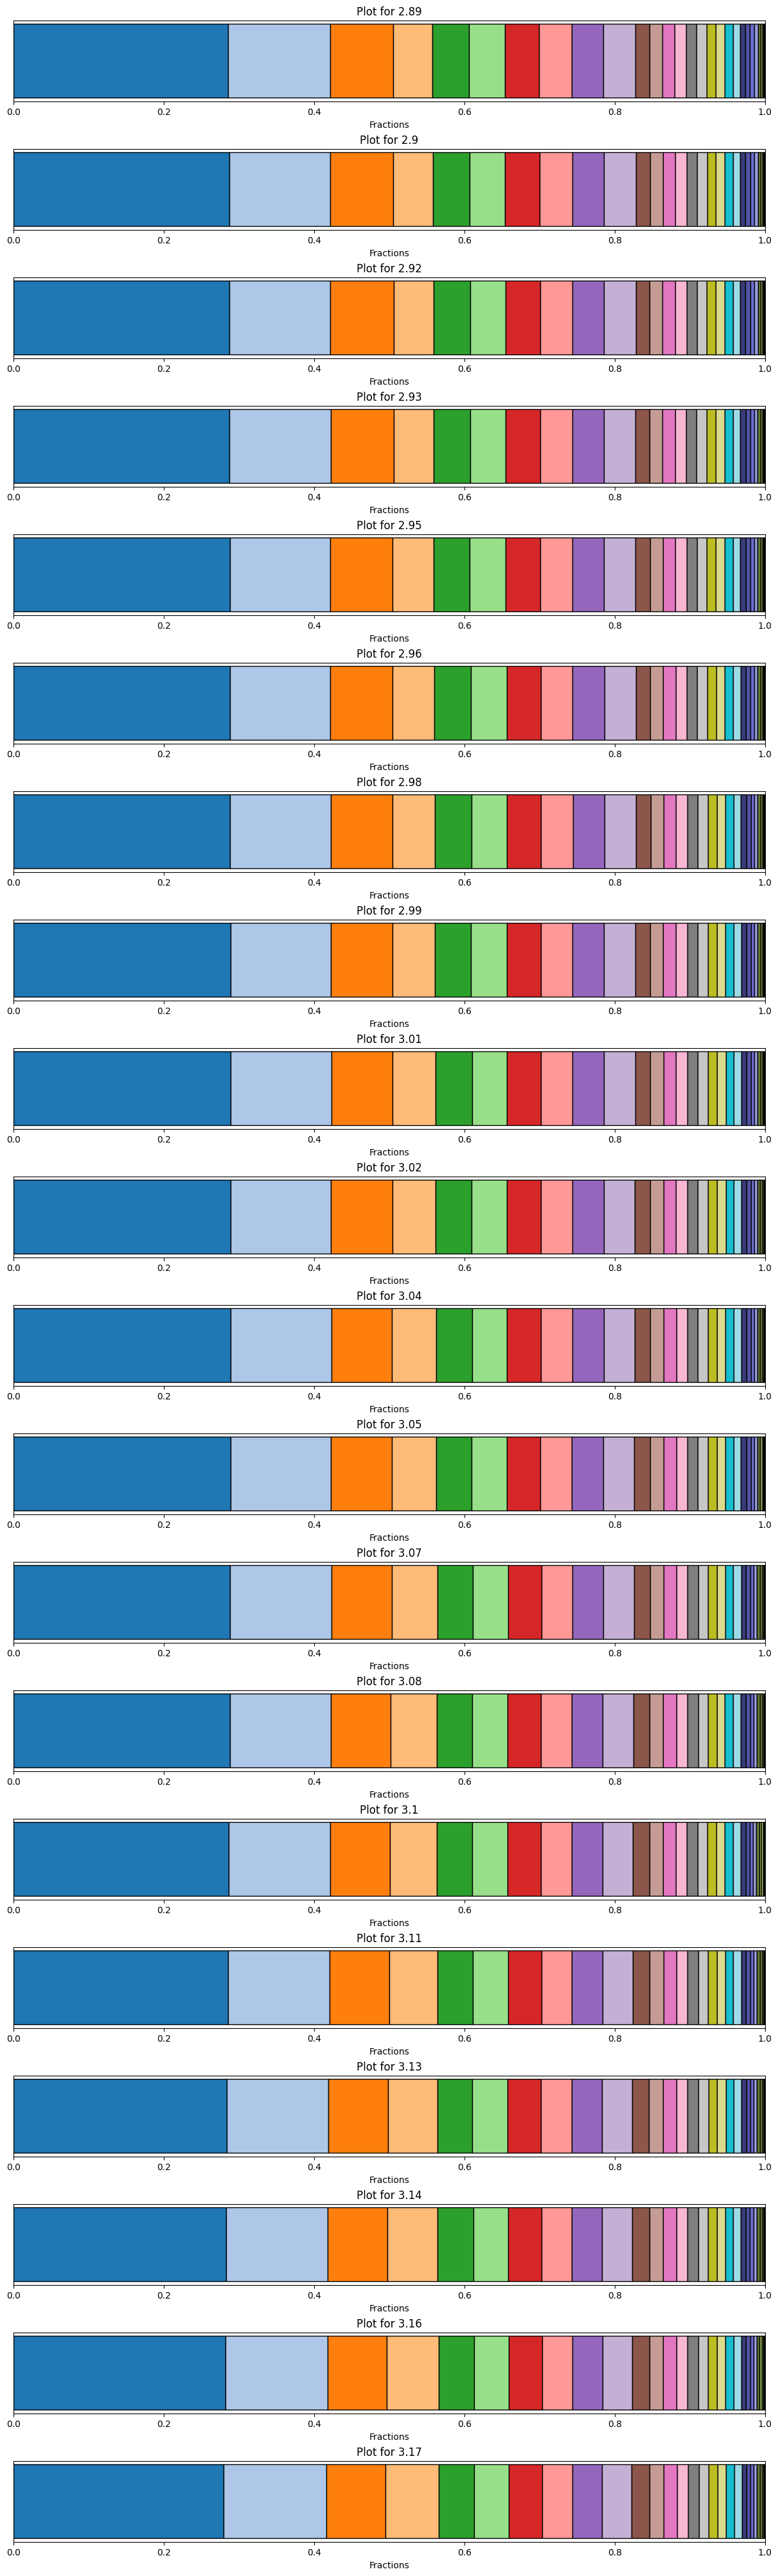

In [156]:
import matplotlib.pyplot as plt
import numpy as np

# Example dictionary for demonstration purposes
# Replace with your actual `ct_dists` dictionary

# Total number of plots
n_plots = len(ct_dists)

# Initialize the figure with multiple subplots, one column
fig, axes = plt.subplots(n_plots, 1, figsize=(12, 2 * n_plots), constrained_layout=True)

# Ensure axes is iterable even if there is one subplot
if n_plots == 1:
    axes = [axes]

# Prepare color palettes
colors = list(plt.get_cmap('tab20').colors) + \
         list(plt.get_cmap('tab20b').colors) + \
         list(plt.get_cmap('tab20c').colors)

# Loop through the dictionary and make individual plots
for ax, (name, ct_pred) in zip(axes, ct_dists.items()):
    n_segments = len(ct_pred)
    fractions = ct_pred["norm"].values  # Fraction values
    categories = ct_pred["cell_type_broad"].values  # Categories
    
    # Select colors for this plot
    color_palette = colors[:n_segments]
    
    # Cumulative fractions for positioning
    cumulative = [0] + list(np.cumsum(fractions)[:-1])
    
    # Plot horizontal bar for each fraction
    for i, (frac, color, cat) in enumerate(zip(fractions, color_palette, categories)):
        ax.barh(0, width=frac, left=cumulative[i], color=color, edgecolor='black', label=cat)
    
    # Aesthetics
    ax.set_xlim(0, 1)
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel("Fractions")
    ax.set_title(f"Plot for {name}")  # Title with dictionary key

# Show the figure
plt.show()


In [157]:
ct_dists_true = {}
for t in [18, 24, 36]:
    df_tmp = adata.obs[(adata.obs["timepoint"]==t) & (adata.obs["gene_target"]==gene_target)]
    df_tmp = df_tmp[df_tmp["cell_type_broad"].isin(cts_meso)]
    ct_tmp = df_tmp["cell_type_broad"].value_counts().to_frame()
    ct_tmp["counts_normalized"] = ct_tmp["count"]/ct_tmp["count"].sum()
    ct_tmp["log_counts_normalized"] = ct_tmp["counts_normalized"]# np.log2(ct_tmp["counts_normalized"]+1+1e-6)
    ct_tmp["norm"] = ct_tmp["log_counts_normalized"]/ct_tmp["log_counts_normalized"].sum()
    ct_tmp["cell_type_broad"] = ct_tmp.index
    ct_dists_true[np.log(t).round(2)] = ct_tmp

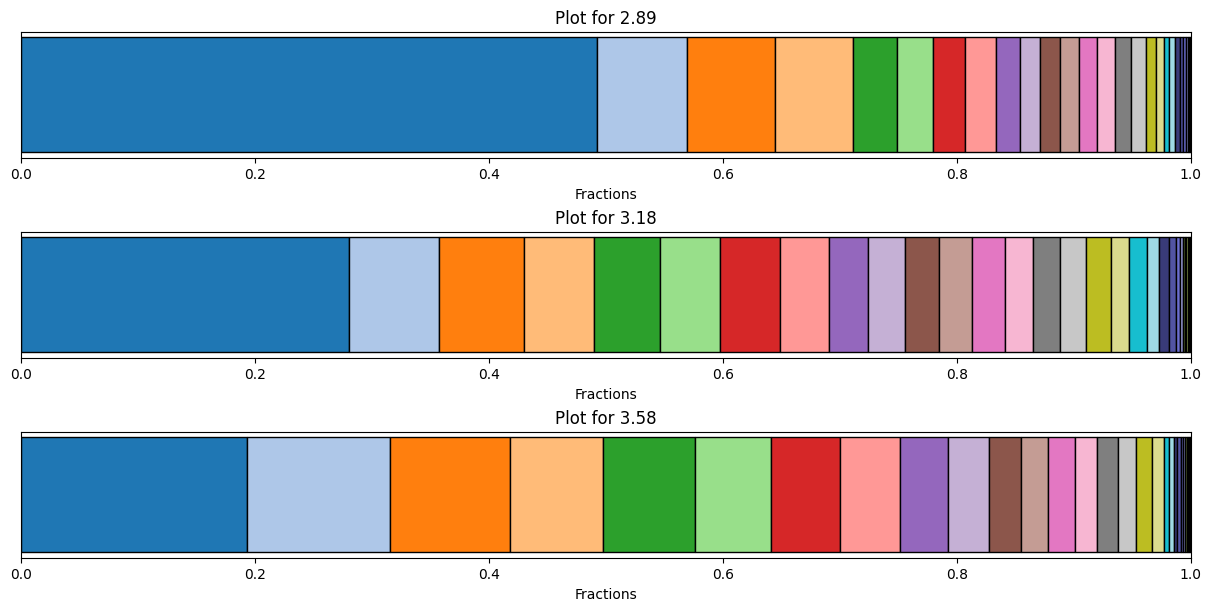

In [158]:
import matplotlib.pyplot as plt
import numpy as np


# Total number of plots
n_plots = len(ct_dists_true)

# Initialize the figure with multiple subplots, one column
fig, axes = plt.subplots(n_plots, 1, figsize=(12, 2 * n_plots), constrained_layout=True)

# Ensure axes is iterable even if there is one subplot
if n_plots == 1:
    axes = [axes]

# Prepare color palettes
colors = list(plt.get_cmap('tab20').colors) + \
         list(plt.get_cmap('tab20b').colors) + \
         list(plt.get_cmap('tab20c').colors)

# Loop through the dictionary and make individual plots
for ax, (name, ct_pred) in zip(axes, ct_dists_true.items()):
    n_segments = len(ct_pred)
    fractions = ct_pred["norm"].values  # Fraction values
    categories = ct_pred["cell_type_broad"].values  # Categories
    
    # Select colors for this plot
    color_palette = colors[:n_segments]
    
    # Cumulative fractions for positioning
    cumulative = [0] + list(np.cumsum(fractions)[:-1])
    
    # Plot horizontal bar for each fraction
    for i, (frac, color, cat) in enumerate(zip(fractions, color_palette, categories)):
        ax.barh(0, width=frac, left=cumulative[i], color=color, edgecolor='black', label=cat)
    
    # Aesthetics
    ax.set_xlim(0, 1)
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel("Fractions")
    ax.set_title(f"Plot for {name}")  # Title with dictionary key

# Show the figure
plt.show()


In [159]:
mat_f_m = {}
for k,v in ct_dists.items():
    mat_f_m[k] = v.loc["mesodermal progenitor cells (contains PSM)"]["norm"]

In [160]:
mat_f_m

{2.89: 0.2852864685948459,
 2.9: 0.2868962256717359,
 2.92: 0.2875275938189846,
 2.93: 0.28768418564336934,
 2.95: 0.2878537085205328,
 2.96: 0.2880541774942909,
 2.98: 0.2884101273785186,
 2.99: 0.2887910705863858,
 3.01: 0.28899190696943505,
 3.02: 0.2889709928464744,
 3.04: 0.2891054865587172,
 3.05: 0.28859745563059525,
 3.07: 0.28831658291457285,
 3.08: 0.28796921627139943,
 3.1: 0.2866452068776007,
 3.11: 0.28592708741669937,
 3.13: 0.28418167580266257,
 3.14: 0.28333463674043946,
 3.16: 0.2821194123163489,
 3.17: 0.28003126221180147}

In [161]:
v.loc["mature slow muscle"]

count                                   909
counts_normalized                  0.071043
log_counts_normalized              0.071043
norm                               0.071043
cell_type_broad          mature slow muscle
Name: mature slow muscle, dtype: object

In [101]:
np.log(18).round(2)

2.89

In [103]:
ct_dists_true[2.89]

,count,counts_normalized,log_counts_normalized,norm,cell_type_broad
cell_type_broad,,,,,
mesodermal progenitor cells (contains PSM),12707,0.131419,0.131419,0.131419,mesodermal progenitor cells (contains PSM)
connective tissue-meninges-dermal FB,11373,0.117622,0.117622,0.117622,connective tissue-meninges-dermal FB
fin mesenchyme,8754,0.090536,0.090536,0.090536,fin mesenchyme
"head mesenchyme (maybe ventral, hand2+)",6493,0.067152,0.067152,0.067152,"head mesenchyme (maybe ventral, hand2+)"
fast-committed myocyte (fusing),5637,0.058299,0.058299,0.058299,fast-committed myocyte (fusing)
...,...,...,...,...,...
adrenal gland,0,0.000000,0.000000,0.000000,adrenal gland
"motor neuron (hindbrain, spinal cord)",0,0.000000,0.000000,0.000000,"motor neuron (hindbrain, spinal cord)"
"mineralized tissue, bone",0,0.000000,0.000000,0.000000,"mineralized tissue, bone"


In [107]:
mat_f_m_true = {}
for k,v in ct_dists_true.items():
    mat_f_m_true[k] = v.loc["mesodermal progenitor cells (contains PSM)"]["norm"]

In [108]:
mat_f_m_true 

{2.89: 0.13141864289334065,
 3.18: 0.051114155619132046,
 3.58: 0.0003914828606893918}

In [106]:
mat_f_m

{2.89: 0.03569277932884437,
 2.9: 0.0362691466083151,
 2.92: 0.036797722045778115,
 2.93: 0.03705325379015928,
 2.95: 0.037547892720306515,
 2.96: 0.03839002515585693,
 2.98: 0.03902065799540934,
 2.99: 0.03921782827179375,
 3.01: 0.03957639609148971,
 3.02: 0.04006768928434958,
 3.04: 0.040543490123322055,
 3.05: 0.041112322791712105,
 3.07: 0.04164849542084605,
 3.08: 0.04246388661760698,
 3.1: 0.04331716885522803,
 3.11: 0.04450005440104451,
 3.13: 0.045723916707443045,
 3.14: 0.046784260515603804,
 3.16: 0.04785935210809052,
 3.17: 0.049305706226947285}